In [484]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from itertools import combinations
import numpy as np
from sklearn.neural_network import MLPClassifier
SEED = 25

# Данные по шахматным турнирам

In [485]:
df = pd.read_csv(r'Data\games.csv')
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [486]:
df.describe()

,created_at,last_move_at,turns,white_rating,black_rating,opening_ply
count,2.005800e+04,2.005800e+04,20058.000000,20058.000000,20058.000000,20058.000000
mean,1.483617e+12,1.483618e+12,60.465999,1596.631868,1588.831987,4.816981
std,2.850151e+10,2.850140e+10,33.570585,291.253376,291.036126,2.797152
min,1.376772e+12,1.376772e+12,1.000000,784.000000,789.000000,1.000000
25%,1.477548e+12,1.477548e+12,37.000000,1398.000000,1391.000000,3.000000
50%,1.496010e+12,1.496010e+12,55.000000,1567.000000,1562.000000,4.000000
75%,1.503170e+12,1.503170e+12,79.000000,1793.000000,1784.000000,6.000000
max,1.504493e+12,1.504494e+12,349.000000,2700.000000,2723.000000,28.000000


In [487]:
df.shape

(20058, 16)

In [488]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


In [489]:
df['rated'].value_counts()

True     16155
False     3903
Name: rated, dtype: int64

In [490]:
df['victory_status'].value_counts()

resign       11147
mate          6325
outoftime     1680
draw           906
Name: victory_status, dtype: int64

In [491]:
df['winner'].value_counts()

white    10001
black     9107
draw       950
Name: winner, dtype: int64

# Предобработка данных

In [492]:
df2 = df.copy()

In [493]:
df2 = df2.drop(['id','increment_code', 'white_id','black_id','moves','opening_eco','opening_name'], axis=1)

In [494]:
df2['rated'] = df['rated'].astype(int)

In [495]:
df2['victory_status'] = df2['victory_status'].replace({'resign':0,
                                                       'mate':1,
                                                       'outoftime':2,
                                                       'draw':3})

In [496]:
df2['winner'] = df2['winner'].replace({'white':0,'black':1,'draw':2})

In [497]:
df2.head()

,rated,created_at,last_move_at,turns,victory_status,winner,white_rating,black_rating,opening_ply
0,0,1.504210e+12,1.504210e+12,13,2,0,1500,1191,5
1,1,1.504130e+12,1.504130e+12,16,0,1,1322,1261,4
2,1,1.504130e+12,1.504130e+12,61,1,0,1496,1500,3
3,1,1.504110e+12,1.504110e+12,61,1,0,1439,1454,3
4,1,1.504030e+12,1.504030e+12,95,1,0,1523,1469,5


In [498]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rated           20058 non-null  int32  
 1   created_at      20058 non-null  float64
 2   last_move_at    20058 non-null  float64
 3   turns           20058 non-null  int64  
 4   victory_status  20058 non-null  int64  
 5   winner          20058 non-null  int64  
 6   white_rating    20058 non-null  int64  
 7   black_rating    20058 non-null  int64  
 8   opening_ply     20058 non-null  int64  
dtypes: float64(2), int32(1), int64(6)
memory usage: 1.3 MB


# Выбор Х и У

In [499]:
y = df2['winner']
x = df2.drop(['winner'], axis=1)

## Перобразование y в массив

In [500]:
y[:3]

0    0
1    1
2    0
Name: winner, dtype: int64

In [501]:
y = y.values.ravel()

In [502]:
x[:3]

,rated,created_at,last_move_at,turns,victory_status,white_rating,black_rating,opening_ply
0,0,1.504210e+12,1.504210e+12,13,2,1500,1191,5
1,1,1.504130e+12,1.504130e+12,16,0,1322,1261,4
2,1,1.504130e+12,1.504130e+12,61,1,1496,1500,3


## Преобразование х в матрицу

In [503]:
x = x.values

In [504]:
x

array([[0.00000000e+00, 1.50421000e+12, 1.50421000e+12, ...,
        1.50000000e+03, 1.19100000e+03, 5.00000000e+00],
       [1.00000000e+00, 1.50413000e+12, 1.50413000e+12, ...,
        1.32200000e+03, 1.26100000e+03, 4.00000000e+00],
       [1.00000000e+00, 1.50413000e+12, 1.50413000e+12, ...,
        1.49600000e+03, 1.50000000e+03, 3.00000000e+00],
       ...,
       [1.00000000e+00, 1.49969788e+12, 1.49969805e+12, ...,
        1.21900000e+03, 1.28600000e+03, 3.00000000e+00],
       [1.00000000e+00, 1.49969613e+12, 1.49969707e+12, ...,
        1.36000000e+03, 1.22700000e+03, 4.00000000e+00],
       [1.00000000e+00, 1.49964315e+12, 1.49964389e+12, ...,
        1.23500000e+03, 1.33900000e+03, 3.00000000e+00]])

# Нейросеть

In [505]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state = SEED)

In [506]:
# train_y = train_y.values.ravel()

In [507]:
train_y

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

In [508]:
train_x

array([[1.00000000e+00, 1.43613532e+12, 1.43613636e+12, ...,
        1.68900000e+03, 1.57800000e+03, 2.00000000e+00],
       [1.00000000e+00, 1.48575534e+12, 1.48575629e+12, ...,
        1.64200000e+03, 1.48500000e+03, 4.00000000e+00],
       [1.00000000e+00, 1.50114957e+12, 1.50115005e+12, ...,
        1.70400000e+03, 1.82400000e+03, 2.00000000e+00],
       ...,
       [1.00000000e+00, 1.49577000e+12, 1.49577000e+12, ...,
        1.78500000e+03, 1.43200000e+03, 5.00000000e+00],
       [1.00000000e+00, 1.47482000e+12, 1.47482000e+12, ...,
        1.42200000e+03, 2.02600000e+03, 5.00000000e+00],
       [0.00000000e+00, 1.46324000e+12, 1.46325000e+12, ...,
        1.73100000e+03, 1.86600000e+03, 2.00000000e+00]])

In [509]:
test_y

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [510]:
test_x

array([[1.00000000e+00, 1.50353000e+12, 1.50353000e+12, ...,
        1.48900000e+03, 1.59200000e+03, 3.00000000e+00],
       [1.00000000e+00, 1.50400396e+12, 1.50400416e+12, ...,
        1.39800000e+03, 1.43600000e+03, 5.00000000e+00],
       [1.00000000e+00, 1.50308294e+12, 1.50308396e+12, ...,
        2.16200000e+03, 2.12200000e+03, 7.00000000e+00],
       ...,
       [1.00000000e+00, 1.50356690e+12, 1.50356727e+12, ...,
        1.59200000e+03, 1.67100000e+03, 5.00000000e+00],
       [0.00000000e+00, 1.49673336e+12, 1.49673421e+12, ...,
        1.79900000e+03, 1.50000000e+03, 8.00000000e+00],
       [1.00000000e+00, 1.50333000e+12, 1.50333000e+12, ...,
        1.96900000e+03, 2.24700000e+03, 5.00000000e+00]])

In [511]:
# train_x = pd.DataFrame(train_x).to_numpy()

## MLPClassifier

In [520]:
model_mlp = MLPClassifier(hidden_layer_sizes=(50,50,50,50), activation='tanh')

In [521]:
model_mlp.fit(train_x, train_y)

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 50, 50, 50))

In [522]:
y_hat_mlp = model_mlp.predict(test_x)

In [523]:
y_hat_mlp

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [524]:
cm_mlp = confusion_matrix(test_y, y_hat_mlp)
cm_mlp

array([[   0, 2011,    0],
       [   0, 1799,    0],
       [   0,  202,    0]], dtype=int64)

In [525]:
precision_recall_fscore_support(test_y, y_hat_mlp)

c:\users\ulaan saan\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([0.        , 0.44840479, 0.        ]),
 array([0., 1., 0.]),
 array([0.        , 0.61917054, 0.        ]),
 array([2011, 1799,  202], dtype=int64))

In [526]:
accuracy_score(test_y, y_hat_mlp)

0.4484047856430708

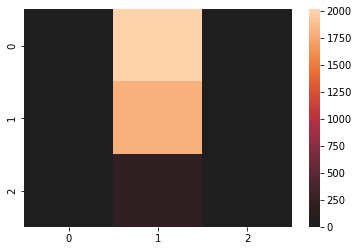

In [527]:
sns.heatmap(cm_mlp, center=True)
plt.show()

# Keras

In [528]:
model_keras = keras.Sequential()
model_keras.add(layers.Dense(150, activation="tanh", kernel_regularizer=keras.regularizers.l2(0.001)))
model_keras.add(layers.Dense(100, activation="tanh", kernel_regularizer=keras.regularizers.l2(0.001)))
model_keras.add(layers.Dense(50, activation="tanh", kernel_regularizer=keras.regularizers.l2(0.001)))
model_keras.add(layers.Dense(10, activation="softmax"))
model_keras.compile(keras.optimizers.SGD(learning_rate=0.001), 
          keras.losses.MeanSquaredError(reduction='sum'),
          metrics=['accuracy']
         )

In [529]:
train_y2 = []
for y in train_y:
    y2 = np.zeros(10)
    y2[y] = 1
    train_y2.append(y2)
    
test_y2 = []
for y in test_y:
    y2 = np.zeros(10)
    y2[y] = 1
    test_y2.append(y2)
    
train_y2 = np.array(train_y2)
test_y2 = np.array(test_y2)

In [530]:
train_y2

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [531]:
train_y2.shape

(16046, 10)

In [532]:
train_x.shape

(16046, 8)

In [533]:
model_keras.fit(train_x, train_y2, epochs=500)

Epoch 1/500
502/502 [==============================] - 1s 1ms/step - loss: 2.0832 - accuracy: 0.4819
Epoch 2/500
502/502 [==============================] - 1s 2ms/step - loss: 1.9473 - accuracy: 0.4852
Epoch 3/500
502/502 [==============================] - 1s 2ms/step - loss: 1.9447 - accuracy: 0.4924
Epoch 4/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9446 - accuracy: 0.4885
Epoch 5/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9411 - accuracy: 0.4909
Epoch 6/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9410 - accuracy: 0.4893
Epoch 7/500
502/502 [==============================] - 1s 2ms/step - loss: 1.9401 - accuracy: 0.4953
Epoch 8/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9394 - accuracy: 0.4910
Epoch 9/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9395 - accuracy: 0.4867
Epoch 10/500
502/502 [==============================] - 1s 2ms/step - loss: 1.9368 - accura

502/502 [==============================] - 1s 1ms/step - loss: 1.9086 - accuracy: 0.4952
Epoch 82/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9083 - accuracy: 0.4941
Epoch 83/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9082 - accuracy: 0.4921
Epoch 84/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9068 - accuracy: 0.4917
Epoch 85/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9069 - accuracy: 0.4924
Epoch 86/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9075 - accuracy: 0.4940
Epoch 87/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9068 - accuracy: 0.4933
Epoch 88/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9061 - accuracy: 0.4925
Epoch 89/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9062 - accuracy: 0.4935
Epoch 90/500
502/502 [==============================] - 1s 1ms/step - loss: 1.9060 - accuracy: 

502/502 [==============================] - 1s 1ms/step - loss: 1.8834 - accuracy: 0.4925
Epoch 161/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8832 - accuracy: 0.4948
Epoch 162/500
502/502 [==============================] - ETA: 0s - loss: 1.8835 - accuracy: 0.49 - 1s 1ms/step - loss: 1.8821 - accuracy: 0.4922
Epoch 163/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8831 - accuracy: 0.4913
Epoch 164/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8822 - accuracy: 0.4941
Epoch 165/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8820 - accuracy: 0.4936
Epoch 166/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8816 - accuracy: 0.4961
Epoch 167/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8809 - accuracy: 0.4897
Epoch 168/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8803 - accuracy: 0.4910
Epoch 169/500
502/502 [======================

502/502 [==============================] - 1s 1ms/step - loss: 1.8623 - accuracy: 0.4944
Epoch 239/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8621 - accuracy: 0.4963
Epoch 240/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8606 - accuracy: 0.4930
Epoch 241/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8614 - accuracy: 0.4948
Epoch 242/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8607 - accuracy: 0.4952
Epoch 243/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8609 - accuracy: 0.4963
Epoch 244/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8605 - accuracy: 0.4928
Epoch 245/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8598 - accuracy: 0.4913
Epoch 246/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8598 - accuracy: 0.4900
Epoch 247/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8591 - a

502/502 [==============================] - 1s 1ms/step - loss: 1.8434 - accuracy: 0.4913
Epoch 318/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8421 - accuracy: 0.4956
Epoch 319/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8428 - accuracy: 0.4945
Epoch 320/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8431 - accuracy: 0.4930
Epoch 321/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8427 - accuracy: 0.4942
Epoch 322/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8424 - accuracy: 0.4923
Epoch 323/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8424 - accuracy: 0.4973
Epoch 324/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8420 - accuracy: 0.4930
Epoch 325/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8417 - accuracy: 0.4973
Epoch 326/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8417 - a

502/502 [==============================] - 1s 1ms/step - loss: 1.8283 - accuracy: 0.4941
Epoch 397/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8275 - accuracy: 0.4945
Epoch 398/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8281 - accuracy: 0.4956
Epoch 399/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8274 - accuracy: 0.4961
Epoch 400/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8276 - accuracy: 0.4966
Epoch 401/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8269 - accuracy: 0.4959
Epoch 402/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8271 - accuracy: 0.4963
Epoch 403/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8268 - accuracy: 0.4952
Epoch 404/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8266 - accuracy: 0.4963
Epoch 405/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8266 - a

502/502 [==============================] - 1s 1ms/step - loss: 1.8143 - accuracy: 0.4981
Epoch 476/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8142 - accuracy: 0.4958
Epoch 477/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8142 - accuracy: 0.4954
Epoch 478/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8143 - accuracy: 0.4941
Epoch 479/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8142 - accuracy: 0.4963
Epoch 480/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8136 - accuracy: 0.4948
Epoch 481/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8133 - accuracy: 0.4963
Epoch 482/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8129 - accuracy: 0.4956
Epoch 483/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8134 - accuracy: 0.4943
Epoch 484/500
502/502 [==============================] - 1s 1ms/step - loss: 1.8127 - a

In [534]:
y_hat_keras = model_keras.predict(test_x)

In [535]:
y_hat_keras

array([[0.4785544 , 0.46801156, 0.04345587, ..., 0.000938  , 0.00179922,
        0.00217526],
       [0.4785544 , 0.46801156, 0.04345587, ..., 0.000938  , 0.00179922,
        0.00217526],
       [0.4785544 , 0.46801156, 0.04345587, ..., 0.000938  , 0.00179922,
        0.00217526],
       ...,
       [0.4785544 , 0.46801156, 0.04345587, ..., 0.000938  , 0.00179922,
        0.00217526],
       [0.4785544 , 0.46801156, 0.04345587, ..., 0.000938  , 0.00179922,
        0.00217526],
       [0.4785544 , 0.46801156, 0.04345587, ..., 0.000938  , 0.00179922,
        0.00217526]], dtype=float32)

In [536]:
test_y

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [537]:
y_hat_keras = [np.argmax(y) for y in y_hat_keras]

In [538]:
y_hat_keras

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [539]:
cm_keras = confusion_matrix(test_y, y_hat_keras)
cm_keras

array([[2011,    0,    0],
       [1799,    0,    0],
       [ 202,    0,    0]], dtype=int64)

In [540]:
precision_recall_fscore_support(test_y, y_hat_keras)

(array([0.50124626, 0.        , 0.        ]),
 array([1., 0., 0.]),
 array([0.66777353, 0.        , 0.        ]),
 array([2011, 1799,  202], dtype=int64))

In [541]:
accuracy_score(test_y, y_hat_keras)

0.501246261216351

In [542]:
model_keras.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 150)               1350      
_________________________________________________________________
dense_47 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_48 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_49 (Dense)             (None, 10)                510       
Total params: 22,010
Trainable params: 22,010
Non-trainable params: 0
_________________________________________________________________


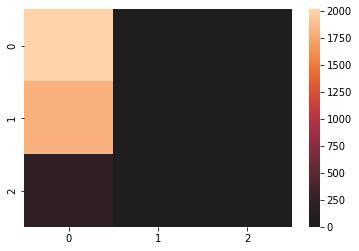

In [543]:
sns.heatmap(cm_keras, center=True)
plt.show()

# Keras 2

In [556]:
train_x3 = train_x
train_y3 = train_y2
test_x3 = test_x
test_y3 = test_y

In [557]:
model_keras2 = keras.Sequential()
model_keras2.add(layers.Dense(150, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model_keras2.add(layers.Dense(100, activation="tanh", kernel_regularizer=keras.regularizers.l2(0.001)))
model_keras2.add(layers.Dense(50, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)))
model_keras2.add(layers.Dense(25, activation="tanh", kernel_regularizer=keras.regularizers.l2(0.001)))
model_keras2.add(layers.Dense(10, activation="softmax"))
model_keras2.compile(keras.optimizers.SGD(learning_rate=0.001), 
          keras.losses.MeanSquaredError(reduction='sum'),
          metrics=['accuracy']
         )

In [558]:
model_keras2.fit(train_x3, train_y3, epochs=25)

Epoch 1/25
502/502 [==============================] - 1s 1ms/step - loss: 2.2230 - accuracy: 0.4545
Epoch 2/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9949 - accuracy: 0.4912
Epoch 3/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9863 - accuracy: 0.4892
Epoch 4/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9822 - accuracy: 0.4923
Epoch 5/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9811 - accuracy: 0.4913
Epoch 6/25
502/502 [==============================] - 1s 2ms/step - loss: 1.9801 - accuracy: 0.4931
Epoch 7/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9793 - accuracy: 0.4948
Epoch 8/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9778 - accuracy: 0.4944
Epoch 9/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9779 - accuracy: 0.4948
Epoch 10/25
502/502 [==============================] - 1s 1ms/step - loss: 1.9776 - accuracy: 0.4938

In [559]:
y_hat_keras2 = model_keras2.predict(test_x3)

In [560]:
y_hat_keras2

array([[0.5039628 , 0.44859228, 0.00335595, ..., 0.0076759 , 0.00401348,
        0.0079568 ],
       [0.5039628 , 0.44859228, 0.00335595, ..., 0.0076759 , 0.00401348,
        0.0079568 ],
       [0.5039628 , 0.44859228, 0.00335595, ..., 0.0076759 , 0.00401348,
        0.0079568 ],
       ...,
       [0.5039628 , 0.44859228, 0.00335595, ..., 0.0076759 , 0.00401348,
        0.0079568 ],
       [0.5039628 , 0.44859228, 0.00335595, ..., 0.0076759 , 0.00401348,
        0.0079568 ],
       [0.5039628 , 0.44859228, 0.00335595, ..., 0.0076759 , 0.00401348,
        0.0079568 ]], dtype=float32)

In [561]:
y_hat_keras2 = [np.argmax(y) for y in y_hat_keras2]

In [562]:
y_hat_keras2

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [563]:
cm_keras2 = confusion_matrix(test_y3, y_hat_keras2)
cm_keras2

array([[2011,    0,    0],
       [1799,    0,    0],
       [ 202,    0,    0]], dtype=int64)

In [564]:
precision_recall_fscore_support(test_y3, y_hat_keras2)

(array([0.50124626, 0.        , 0.        ]),
 array([1., 0., 0.]),
 array([0.66777353, 0.        , 0.        ]),
 array([2011, 1799,  202], dtype=int64))

In [565]:
accuracy_score(test_y3, y_hat_keras2)

0.501246261216351

In [566]:
model_keras2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_55 (Dense)             (None, 150)               1350      
_________________________________________________________________
dense_56 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_57 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_58 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_59 (Dense)             (None, 10)                260       
Total params: 23,035
Trainable params: 23,035
Non-trainable params: 0
_________________________________________________________________


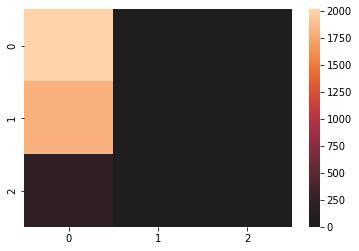

In [567]:
sns.heatmap(cm_keras2, center=True)
plt.show()

# Сверточные сети

In [ ]:
# model_conv = keras.Sequential()
# model_conv.add(layers.Conv1D(32, 3, activation='relu'))
# model_conv.add(layers.Conv1D(32, 3, activation='relu'))
# model_conv.add(layers.Conv1D(32, 3, activation='relu'))
# model_conv.add(layers.Flatten())
# model_conv.add(layers.Dense(10, activation="softmax"))

# model_conv.compile(keras.optimizers.Adam(learning_rate=0.001), keras.losses.MeanSquaredError(reduction='sum'))

In [ ]:
# train_y2 = []
# for y in train_y:
#     y2 = np.zeros(8)
#     y2[y] = 1
#     train_y2.append(y2)
    
# test_y2 = []
# for y in test_y:
#     y2 = np.zeros(8)
#     y2[y] = 1
#     test_y2.append(y2)
    
# train_y2 = np.array(train_y2)
# test_y2 = np.array(test_y2)

In [ ]:
# train_x.shape

In [ ]:
# train_y2.shape

In [ ]:
# test_x.shape

In [ ]:
# train_x3 = train_x
# train_y3 = train_y2
# test_x3 = test_x
# test_y3 = test_y2

In [ ]:
# train_x3 = train_x.reshape(16046, 1, -1)
# train_y3 = train_y2.reshape(-1, 1, 8)
# test_x3 = test_x.reshape(-1, 32096, 1)
# test_y3 = test_y2.reshape(-1, 8, 1)

In [ ]:
# train_x3.shape

In [ ]:
# train_x3[:5]

In [ ]:
# train_y3.shape

In [ ]:
# train_y3[:5]

In [ ]:
# model_conv.fit(train_x3, train_y3, epochs=20)